In [1]:
#Ligar o notebook ao google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import librosa.display
import pandas as pd
import os
import glob
import pickle as pkl
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Dataframe com os dados de cada áudio

urbansound8k = pd.read_csv('/content/drive/MyDrive/trabalho_AC2/UrbanSound8K.csv')
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
#Mapear as classes para números

class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling',
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}

pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [5]:
#Número de exemplos para cada classe

urbansound8k['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

<Axes: title={'center': 'Sounds'}, ylabel='class'>

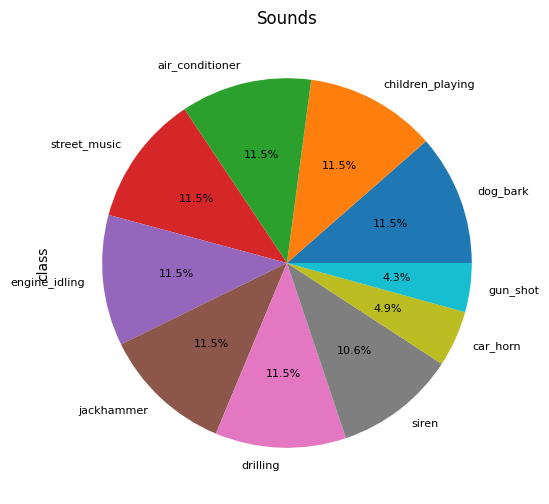

In [ ]:
#Gráfico circular para o número de vezes que cada classe aparece

urbansound8k['class'].value_counts().plot(kind='pie', figsize=(6, 6), title='Sounds', autopct='%1.1f%%', shadow = False, fontsize=8)

In [ ]:
#Criar uma coluna no dataframe para a duração do áudio

urbansound8k['duration'] = urbansound8k['end']-urbansound8k['start']

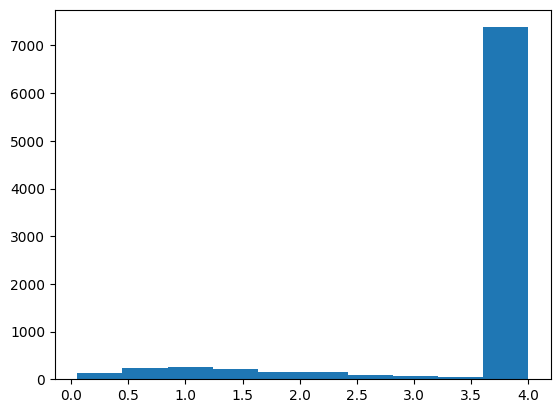

In [ ]:
#Gráfico de barras para a duração dos aúdios

n, bins, patches = plt.hist(urbansound8k["duration"], bins=10)

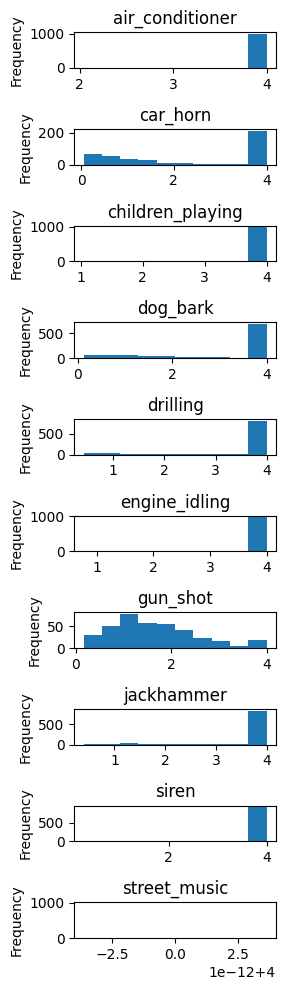

In [ ]:
"""
Gráficos de de barras para a duração dos aúdios de cada classe
Por algum motivo o gráfico para a street_music aparece errado, mas a duração é sempre 4 segundos
"""

urbansound8k.plot.hist(bins=10, column=["duration"], by="class", figsize=(3, 10), legend=False)
plt.tight_layout()

In [ ]:
#Ficheiro para retirar os exemplos

file_viz = glob.glob('/content/drive/MyDrive/trabalho_AC2/audio/fold1/*')

In [ ]:
#Exemplo de cada classe

samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0])
           for label in class_map.keys()]

print(samples)

[('air_conditioner', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/127873-0-0-0.wav'), ('car_horn', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/156194-1-0-0.wav'), ('children_playing', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/105415-2-0-15.wav'), ('dog_bark', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/101415-3-0-2.wav'), ('drilling', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/14113-4-0-1.wav'), ('engine_idling', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/103258-5-0-0.wav'), ('gun_shot', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/102305-6-0-0.wav'), ('jackhammer', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/103074-7-0-1.wav'), ('siren', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/106905-8-0-1.wav'), ('street_music', '/content/drive/MyDrive/trabalho_AC2/audio/fold1/108041-9-0-5.wav')]


In [ ]:
#Função para obter os dados de um som

def get_sound_data(path, sr=22050):

    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T,orig_sr=fsr, target_sr=sr)

    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)

    return data_22k, sr


In [ ]:
#Lista com os dados dos exemplos

sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (44982,)),
 ('car_horn', (5513,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (57551,)),
 ('jackhammer', (88200,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

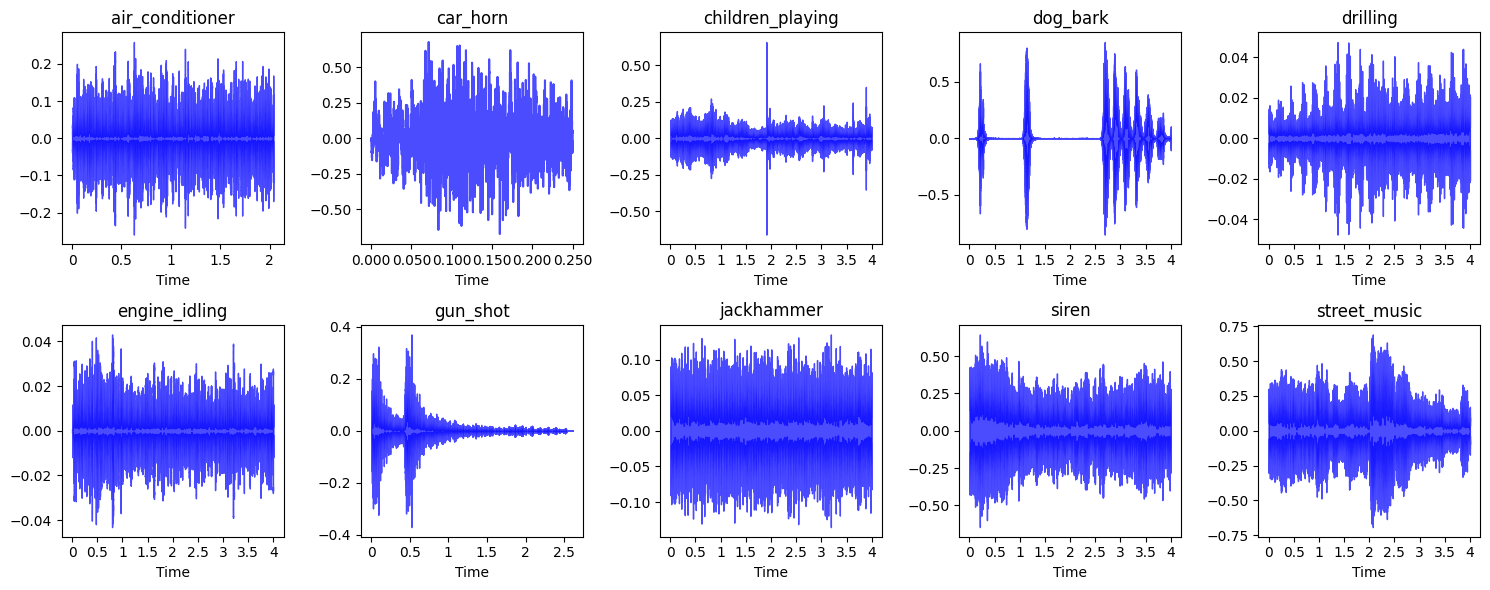

In [ ]:
#Visualização dos exemplos

i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], color='b', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [6]:
#Ficheiros para testar os processos de adicionar ruido e obter os mfccs

test_dir="/content/drive/MyDrive/trabalho_AC2/audio/fold2"
test_files = librosa.util.find_files(test_dir)

In [ ]:
"""
Obter um dataset com os sons normais e outro em que. no caso da duração ser inferior
a quatro segundos, o som é repetido até serem obtidos os 4 segundos
"""

target_sr = 44100

n_mfcc=40
hop_length=round(target_sr*0.0125)
win_length=round(target_sr*0.023)
n_fft=2**14
mfcc_time_size = 4*target_sr//hop_length+1

dataset_repeated=np.zeros(shape=[len(test_files),4*target_sr])
dataset_mfcc=np.zeros(shape=[len(test_files),n_mfcc,mfcc_time_size])

i = 0
for f in tqdm(test_files):
    (sig, rate) = librosa.load(f, sr=None)
    sig_res = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    while len(sig_res) < 4 * target_sr:
        sig_res = np.concatenate((sig_res, sig_res), axis=0)

    sig_res_repeat = sig_res[:4 * target_sr]
    dataset_repeated[i] = sig_res_repeat

    sig_mfcc =librosa.feature.mfcc(y=sig_res_repeat,sr=target_sr,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
    dataset_mfcc[i]=sig_mfcc

    i += 1


100%|██████████| 888/888 [03:23<00:00,  4.37it/s]


In [ ]:
#Função para imprimir o som e mfccs

def plot_sound_and_mfcc(index):
    plt.figure()
    plt.plot(np.asarray(list(range(4*target_sr)))/target_sr,dataset_repeated[index])
    plt.show()
    plt.figure()
    plt.imshow(dataset_mfcc[index])
    plt.show()



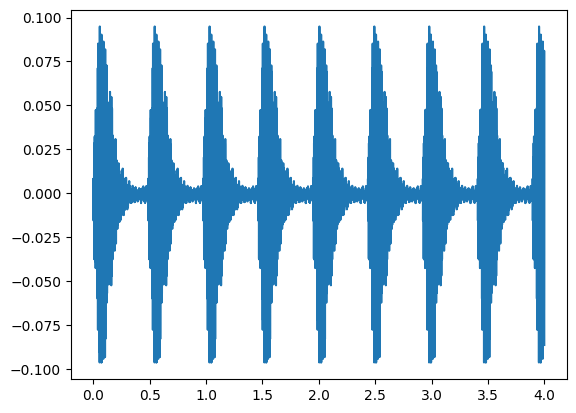

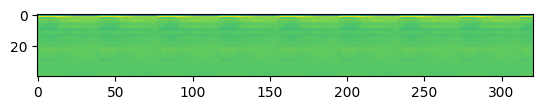

In [ ]:
#Exemplo 1
plot_sound_and_mfcc(300)

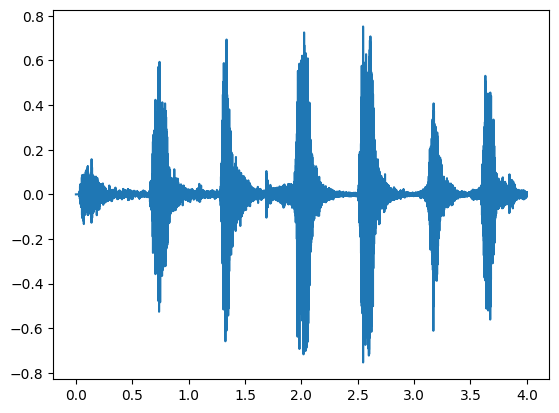

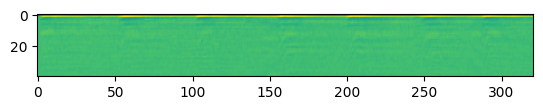

In [ ]:
#Exemplo 2
plot_sound_and_mfcc(0)

In [ ]:
#Função para imprimir o som antes e depois de ser acrescentado ruido

def plot_sound_and_noise(index):
    sound = dataset_repeated[index]
    noise=np.random.normal(0, 0.008, sound.shape[0])
    sound_with_noise = sound+noise
    plt.figure()
    plt.plot(np.asarray(list(range(4*target_sr)))/target_sr,sound)
    plt.show()
    plt.figure()
    plt.plot(np.asarray(list(range(4*target_sr)))/target_sr,sound_with_noise)
    plt.show()


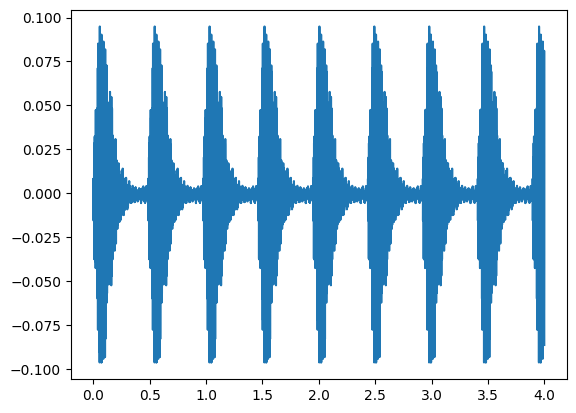

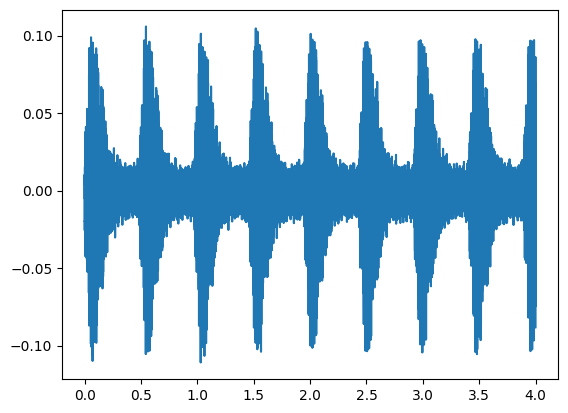

In [ ]:
#Exemplo 1
plot_sound_and_noise(300)

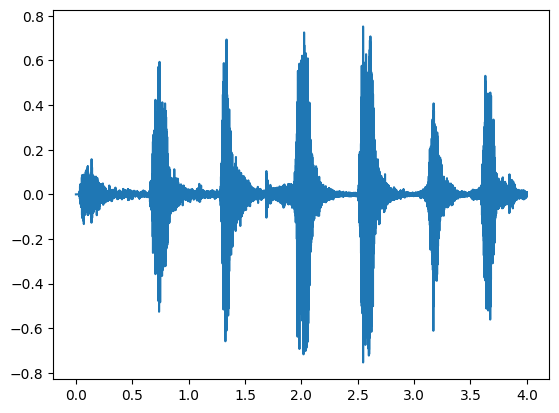

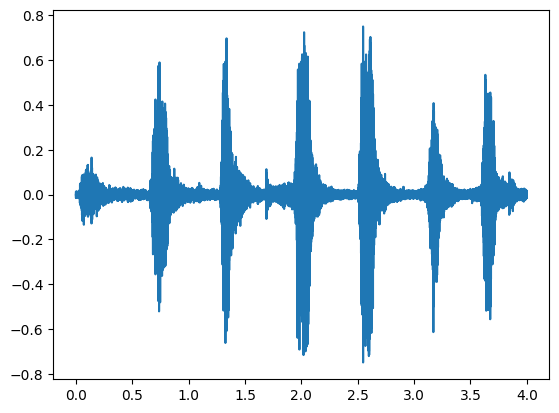

In [ ]:
#Exemplo 2
plot_sound_and_noise(0)

In [ ]:
"""
Função para obter os sons, os mfccs e as respetivas classes para cada salience

Como os mfccs e as classes são colocadas no array da respetiva salience na posição correspondente à posição do som na lista
total dos sons da fold, é preciso filtrar as posições que não foram preenchidas
"""

def pipeline(files, fold):
    target_sr = 44100

    n_mfcc=40
    hop_length=round(target_sr*0.0125)
    win_length=round(target_sr*0.023)
    n_fft=2**14
    mfcc_time_size = 4*target_sr//hop_length+1

    dataset_sounds_1 = np.zeros(shape=[len(files),4*target_sr])
    dataset_mfcc_1 = np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])
    dataset_classes_1=np.zeros(len(files))

    dataset_sounds_2 = np.zeros(shape=[len(files),4*target_sr])
    dataset_mfcc_2 = np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])
    dataset_classes_2 = np.zeros(len(files))


    i = 0
    for f in tqdm(files):
        sig, rate = librosa.load(f"/content/drive/MyDrive/trabalho_AC2/audio/{fold}/{f}", sr=None)
        sig_res = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

        salience = urbansound8k[urbansound8k['slice_file_name'] == f]['salience'].values[0].astype(int)

        while len(sig_res) < 4 * target_sr:
            sig_res = np.concatenate((sig_res, sig_res), axis=0)
        sig_res_repeat = sig_res[:4 * target_sr]
        noise=np.random.normal(0, 0.008, sig_res_repeat.shape[0])
        sig_res_repeat += noise

        sig_mfcc =librosa.feature.mfcc(y=sig_res_repeat,sr=target_sr,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)

        class_number = urbansound8k[urbansound8k['slice_file_name'] == f]['classID'].values[0].astype(int)
        if class_number == 0:
            class_number = 11

        if salience == 1:
            dataset_sounds_1[i] = sig_res_repeat
            dataset_mfcc_1[i] = sig_mfcc
            dataset_classes_1[i] = class_number
        elif salience == 2:
            dataset_sounds_2[i] = sig_res_repeat
            dataset_mfcc_2[i] = sig_mfcc
            dataset_classes_2[i] = class_number

            i += 1
    return dataset_sounds_1, dataset_mfcc_1, dataset_classes_1, dataset_sounds_2, dataset_mfcc_2, dataset_classes_2


In [ ]:
#Diretório com os ficheiros
audio_dir = "/content/drive/MyDrive/trabalho_AC2/audio/"

In [ ]:
#Lista com o nome das folds
fold_dirs = os.listdir(audio_dir)
print(fold_dirs)

['fold9', 'fold10', 'fold4', 'fold5', 'fold7', 'fold2', 'fold1', 'fold3', 'fold6', 'fold8']


In [ ]:
#Caminho para o ficheiro que vai receber os arrays com os mfccs e as classes
features_path = "/content/drive/MyDrive/trabalho_AC2/features"

In [ ]:
#Função para retirar os valores não preenchidos no array dos mfccs

def filter_mfccs(array):
    
    sum_slice = np.sum(array, axis=(1, 2))

    non_zero_indices = np.where(sum_slice != 0)[0]

    filtered_array = array[non_zero_indices]

    print(f"{array.shape} -> {filtered_array.shape}")

    return filtered_array

In [ ]:
#Função para retirar os valores não preenchidos no array das classes

def filter_classes(array):

    sum_slice = np.sum(array)

    non_zero_indices = np.where(array != 0)[0]

    filtered_array = array[non_zero_indices]

    print(f"{array.shape} -> {filtered_array.shape}")

    return filtered_array

In [ ]:
#Obter e guardar os arrays com os mfccs e as classes nas respetivas pastas

for fold in fold_dirs:
    files = os.listdir(f"{audio_dir}{fold}")
    ds_sounds_1, ds_mfccs_1, ds_classes_1, ds_sounds_2, ds_mfccs_2, ds_classes_2 = pipeline(files, fold)

    ds_classes_1 = ds_classes_1.astype(int)
    ds_classes_2 = ds_classes_2.astype(int)

    ds_mfccs_1 = filter_mfccs(ds_mfccs_1)
    ds_classes_1 = filter_classes(ds_classes_1)
    ds_mfccs_2 = filter_mfccs(ds_mfccs_2)
    ds_classes_2 = filter_classes(ds_classes_2)

    ds_classes_1[ds_classes_1 == 11] = 0
    ds_classes_2[ds_classes_2 == 11] = 0

    fold_dir = f"{features_path}/{fold}"
    os.makedirs(fold_dir)

    salience_dir_1 = f"{features_path}/{fold}/salience1"
    os.makedirs(salience_dir_1)

    mfccs_path_1 = os.path.join(salience_dir_1, 'mfccs.pkl')
    with open(mfccs_path_1, 'wb') as file:
        pkl.dump(ds_mfccs_1, file)

    classes_path_1 = os.path.join(salience_dir_1, 'classes.pkl')
    with open(classes_path_1, 'wb') as file:
        pkl.dump(ds_classes_1, file)

    salience_dir_2 = f"{features_path}/{fold}/salience2"
    os.makedirs(salience_dir_2)

    mfccs_path_2 = os.path.join(salience_dir_2, 'mfccs.pkl')
    with open(mfccs_path_2, 'wb') as file:
        pkl.dump(ds_mfccs_2, file)

    classes_path_2 = os.path.join(salience_dir_2, 'classes.pkl')
    with open(classes_path_2, 'wb') as file:
        pkl.dump(ds_classes_2, file)



100%|██████████| 816/816 [02:45<00:00,  4.94it/s]


(816, 40, 321) -> (550, 40, 321)
(816,) -> (550,)
(816, 40, 321) -> (266, 40, 321)
(816,) -> (266,)


100%|██████████| 837/837 [03:12<00:00,  4.35it/s]


(837, 40, 321) -> (568, 40, 321)
(837,) -> (568,)
(837, 40, 321) -> (269, 40, 321)
(837,) -> (269,)


100%|██████████| 990/990 [03:49<00:00,  4.31it/s]


(990, 40, 321) -> (558, 40, 321)
(990,) -> (558,)
(990, 40, 321) -> (432, 40, 321)
(990,) -> (432,)


100%|██████████| 936/936 [03:31<00:00,  4.43it/s]


(936, 40, 321) -> (663, 40, 321)
(936,) -> (663,)
(936, 40, 321) -> (273, 40, 321)
(936,) -> (273,)


100%|██████████| 838/838 [03:12<00:00,  4.35it/s]


(838, 40, 321) -> (526, 40, 321)
(838,) -> (526,)
(838, 40, 321) -> (312, 40, 321)
(838,) -> (312,)


100%|██████████| 888/888 [03:08<00:00,  4.71it/s]


(888, 40, 321) -> (558, 40, 321)
(888,) -> (558,)
(888, 40, 321) -> (330, 40, 321)
(888,) -> (330,)


100%|██████████| 873/873 [03:01<00:00,  4.82it/s]


(873, 40, 321) -> (622, 40, 321)
(873,) -> (622,)
(873, 40, 321) -> (251, 40, 321)
(873,) -> (251,)


100%|██████████| 925/925 [03:34<00:00,  4.31it/s]


(925, 40, 321) -> (590, 40, 321)
(925,) -> (590,)
(925, 40, 321) -> (335, 40, 321)
(925,) -> (335,)


100%|██████████| 823/823 [03:07<00:00,  4.38it/s]


(823, 40, 321) -> (515, 40, 321)
(823,) -> (515,)
(823, 40, 321) -> (308, 40, 321)
(823,) -> (308,)


100%|██████████| 806/806 [03:00<00:00,  4.48it/s]


(806, 40, 321) -> (552, 40, 321)
(806,) -> (552,)
(806, 40, 321) -> (254, 40, 321)
(806,) -> (254,)
